# CMMA Dynamic Sizing Strategy with Transaction Costs

This notebook implements a CMMA-based dynamic position sizing strategy for Squid_Ink with transaction costs included in the parameter optimization process.

In [16]:
# Import necessary libraries
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import our backtester package
sys.path.append(os.path.abspath('../../'))
from backtester import get_price_data, get_vwap
print("Using backtester package")

Using backtester package


## 1. Load Data

First, let's load the real price data for Squid_Ink.

In [2]:
# Load data directly using backtester package
print("Loading price data...")
prices = get_price_data('SQUID_INK', 1)
print(f"Loaded {len(prices)} price data points")

# Limit to first 20,000 timestamps (in-sample data)
in_sample_prices = prices.iloc[:20000]
print(f"Limited to {len(in_sample_prices)} in-sample data points")

# Get VWAP
if 'vwap' in in_sample_prices.columns:
    squid_vwap = in_sample_prices['vwap']
    print("Using VWAP column from data")
else:
    # Calculate VWAP if not available
    squid_vwap = get_vwap(in_sample_prices, 'SQUID_INK')
    print("Calculated VWAP from data")

print(f"VWAP range: {squid_vwap.min()} to {squid_vwap.max()}")

# Calculate log prices
log_prices = np.log(squid_vwap)
print(f"Calculated log prices")

# Calculate returns
returns = squid_vwap.pct_change().dropna()
print(f"Calculated returns with {len(returns)} data points")

Loading price data...
Loading real data for SQUID_INK from round 1...
Found data file at ../../../Prosperity 3 Data/Round 1/prices_round_1_day_-2.csv
Found data file at ../../../Prosperity 3 Data/Round 1/prices_round_1_day_-1.csv
Found data file at ../../../Prosperity 3 Data/Round 1/prices_round_1_day_0.csv
Successfully loaded real data with 30000 rows
Loaded 30000 price data points
Limited to 20000 in-sample data points
Using VWAP column from data
VWAP range: 1832.0 to 2187.3880597014927
Calculated log prices
Calculated returns with 19999 data points


## 2. Calculate CMMA Indicator

Now, let's calculate the CMMA indicator using log prices.

Calculated CMMA with lookback 10
Calculated CMMA with lookback 20
Calculated CMMA with lookback 50


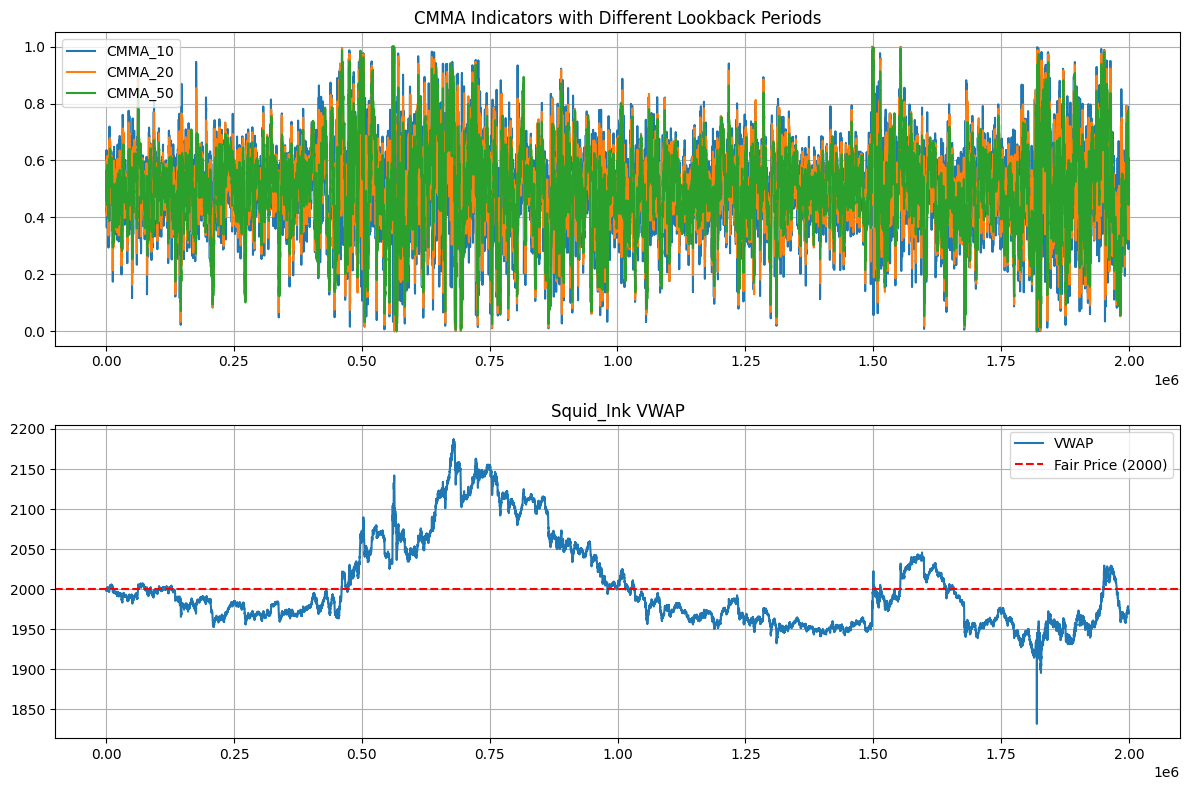

In [17]:
def calculate_cmma_log(log_prices, lookback=10):
    """
    Compute the Cumulative Moving Average Momentum (CMMA) using log prices.
    
    Parameters:
        log_prices (pd.Series): Series of log prices
        lookback (int): Lookback period
        
    Returns:
        pd.Series: CMMA indicator (0-1 range)
    """
    # Calculate raw CMMA using log prices
    raw_cmma = (log_prices - log_prices.ewm(span=lookback).mean().shift(1)).divide(np.sqrt(lookback+1)).dropna()
    
    # Normalize using sigmoid function
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    cmma = sigmoid(raw_cmma)
    return cmma

# Calculate CMMA with different lookback periods
lookback_periods = [10, 20, 50]
cmma_indicators = {}

for lookback in lookback_periods:
    cmma_indicators[f'CMMA_{lookback}'] = calculate_cmma_log(squid_vwap, lookback)
    print(f'Calculated CMMA with lookback {lookback}')

# Plot CMMA indicators
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
for lookback in lookback_periods:
    plt.plot(cmma_indicators[f'CMMA_{lookback}'], label=f'CMMA_{lookback}')
plt.title('CMMA Indicators with Different Lookback Periods')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(squid_vwap, label='VWAP')
plt.axhline(y=2000, color='r', linestyle='--', label='Fair Price (2000)')
plt.title('Squid_Ink VWAP')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 3. Implement Dynamic Position Sizing Strategy

Now, let's implement the dynamic position sizing strategy using the CMMA indicator.

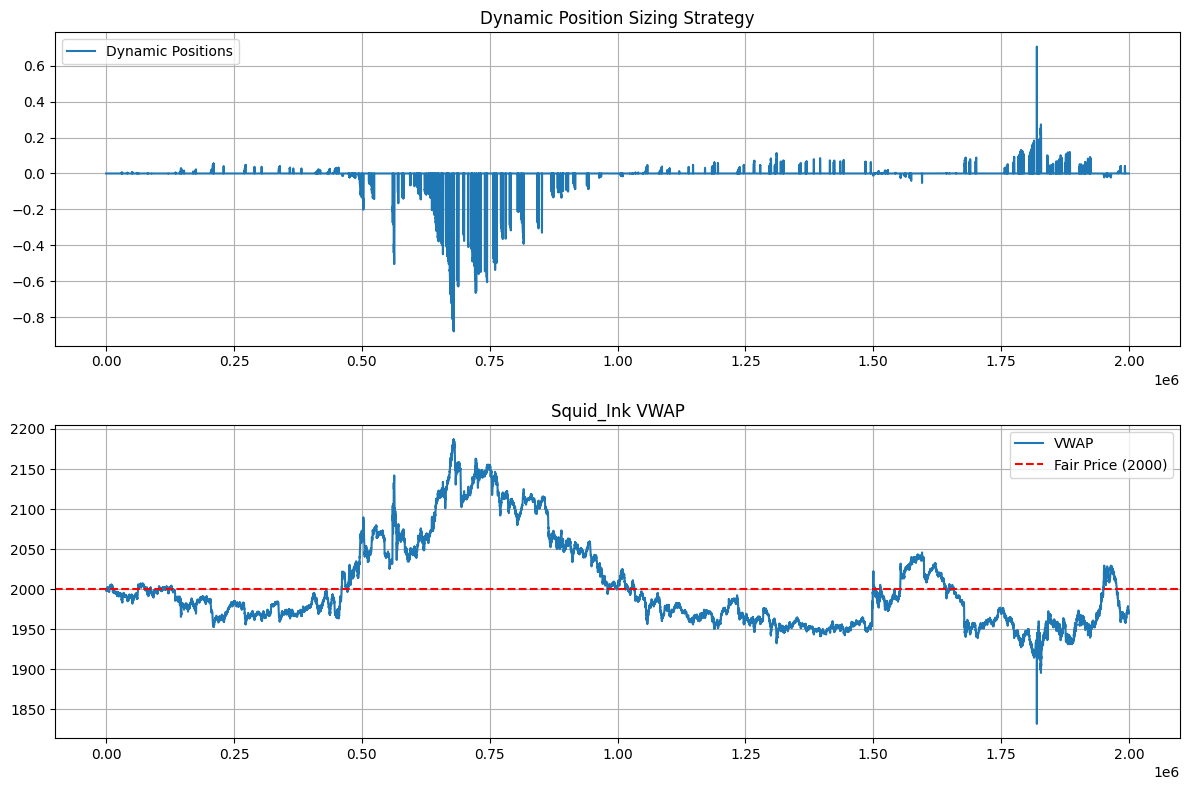

In [18]:
def calculate_exponential_position(price, fair_price=2000, price_range=200, exponent=2.0, max_position=1.0):
    """
    Calculate position size that scales exponentially as price moves away from fair price.
    
    Parameters:
        price (float): Current price
        fair_price (float): Fair price (position is 0 at this price)
        price_range (float): Base price range for scaling
        exponent (float): Exponent for scaling (higher = more aggressive exponential growth)
        max_position (float): Maximum position size (absolute value)
        
    Returns:
        float: Position size between -max_position and max_position
    """
    # Calculate normalized deviation from fair price
    normalized_deviation = (price - fair_price) / price_range
    
    # Calculate position size using exponential scaling (negative deviation = positive position)
    if normalized_deviation > 0:
        # Price is above fair price -> short position
        position = -np.sign(normalized_deviation) * min(abs(normalized_deviation) ** exponent, 1.0) * max_position
    else:
        # Price is below fair price -> long position
        position = -np.sign(normalized_deviation) * min(abs(normalized_deviation) ** exponent, 1.0) * max_position
    
    return position

def cmma_dynamic_position_strategy(prices, cmma, fair_price, upper_threshold=0.7, lower_threshold=0.3, 
                                  price_range=200, exponent=2.0, max_position=1.0, update_frequency=1):
    """
    Implement a CMMA-filtered mean reversion strategy with dynamic position sizing.
    
    Parameters:
        prices (pd.Series): Series of prices
        cmma (pd.Series): CMMA indicator
        fair_price (float): Fair price to revert to
        upper_threshold (float): Upper threshold for CMMA
        lower_threshold (float): Lower threshold for CMMA
        price_range (float): Base price range for scaling positions
        exponent (float): Exponent for scaling (higher = more aggressive exponential growth)
        max_position (float): Maximum position size (absolute value)
        update_frequency (int): Number of timestamps between position updates
        
    Returns:
        pd.Series: Portfolio positions (continuous values between -max_position and max_position)
    """
    # Initialize positions
    positions = pd.Series(0.0, index=prices.index)
    
    # Get valid indices where CMMA is not NaN
    valid_indices = cmma.dropna().index
    
    # Track the last update time
    last_update_idx = -update_frequency  # Start with immediate update
    current_position = 0.0
    
    # Set positions based on CMMA and fair price
    for time in valid_indices:
        # Get the current price and CMMA value
        current_price = prices.loc[time]
        current_cmma = cmma.loc[time]
        
        # Get the index position
        idx = prices.index.get_loc(time)
        
        # Only update position at specified frequency
        if idx - last_update_idx >= update_frequency:
            # ONLY short above fair price when CMMA is high (strong momentum)
            if current_price > fair_price and current_cmma > upper_threshold:
                # Calculate dynamic position size (short)
                current_position = calculate_exponential_position(
                    current_price, fair_price, price_range, exponent, max_position
                )
                # Ensure it's a short position (negative)
                current_position = min(current_position, 0.0)
            
            # ONLY buy below fair price when CMMA is low (weak momentum)
            elif current_price < fair_price and current_cmma < lower_threshold:
                # Calculate dynamic position size (long)
                current_position = calculate_exponential_position(
                    current_price, fair_price, price_range, exponent, max_position
                )
                # Ensure it's a long position (positive)
                current_position = max(current_position, 0.0)
            else:
                # No signal, close position
                current_position = 0.0
                
            # Update last update index
            last_update_idx = idx
        
        # Set the current position
        positions.iloc[idx] = current_position
    
    return positions

# Define the fair price
FAIR_PRICE = 2000

# Choose a specific lookback period for testing
lookback = 20
cmma_log = cmma_indicators[f'CMMA_{lookback}']

# Define parameters for testing
upper_threshold = 0.7  # Upper threshold for CMMA
lower_threshold = 0.3  # Lower threshold for CMMA

# Parameters for dynamic position sizing
price_range = 200      # Base price range for scaling
exponent = 2.0         # Exponent for scaling
max_position = 1.0     # Maximum position size
update_frequency = 1   # Update frequency

# Run the dynamic position strategy
dynamic_positions = cmma_dynamic_position_strategy(
    squid_vwap, cmma_log, FAIR_PRICE, upper_threshold, lower_threshold,
    price_range, exponent, max_position, update_frequency
)

# Plot the strategy positions
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(dynamic_positions, label='Dynamic Positions')
plt.title('Dynamic Position Sizing Strategy')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(squid_vwap, label='VWAP')
plt.axhline(y=FAIR_PRICE, color='r', linestyle='--', label=f'Fair Price ({FAIR_PRICE})')
plt.title('Squid_Ink VWAP')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 4. Implement Transaction Cost Calculation

Now, let's implement a function to calculate returns with transaction costs.

<Axes: xlabel='timestamp'>

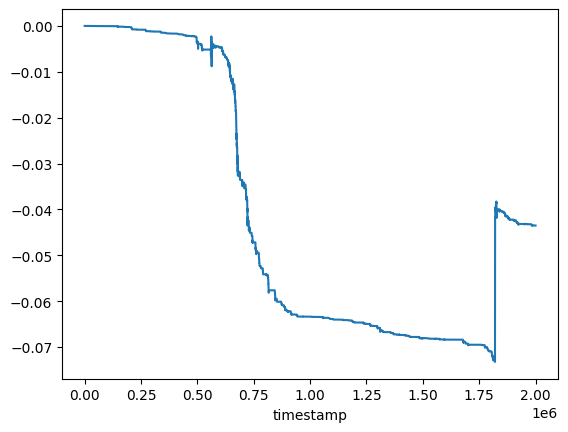

In [12]:
def calculate_returns_with_costs(positions, returns, cost_per_dollar=0.00075):
    """
    Calculate strategy returns with transaction costs.
    
    Parameters:
        positions (pd.Series): Series of positions
        returns (pd.Series): Series of price returns
        cost_per_dollar (float): Transaction cost per dollar traded (default: 0.075%)
        
    Returns:
        pd.Series: Strategy returns with transaction costs
    """
    # Calculate position changes (absolute value)
    position_changes = positions.diff().abs()
    
    # Calculate transaction costs
    transaction_costs = position_changes * cost_per_dollar
    
    # Calculate raw strategy returns
    raw_returns = positions.shift(1) * returns
    
    # Subtract transaction costs from raw returns
    net_returns = raw_returns - transaction_costs
    
    return net_returns.dropna()

# Define transaction cost (1.5/2000 = 0.075% per dollar traded)
transaction_cost = 1.5/2000  # 0.075% per dollar traded

# Calculate returns without transaction costs
raw_returns = dynamic_positions.shift(1) * returns
raw_returns = raw_returns.dropna()

# Calculate returns with transaction costs
returns_with_costs = calculate_returns_with_costs(dynamic_positions, returns, transaction_cost)
import seaborn as sns 
sns.lineplot(returns_with_costs.cumsum())


## 5. Parameter Optimization with Transaction Costs

Now, let's optimize the parameters for the CMMA dynamic position sizing strategy with transaction costs included in the evaluation.

In [ ]:
# Define parameter ranges to test
price_ranges = [200, 300]       # Base price ranges for scaling
exponents = [0.5, 1.0, 1.5, 2.0, 2.5]     # Exponents for scaling
max_positions = [1.0]      # Maximum position sizes
update_frequencies = [1]      # Update frequencies

# Define CMMA threshold ranges to test
upper_thresholds = [0.6, 0.7, 0.8]  # Upper thresholds for CMMA
lower_thresholds = [0.2, 0.3, 0.4]  # Lower thresholds for CMMA

# Define transaction cost (1.5/2000 = 0.075% per dollar traded)
transaction_cost = 1.5/2000  # 0.075% per dollar traded

# Initialize results dictionary
param_results = []

# Test different parameter combinations
for price_range in price_ranges:
    for exponent in exponents:
        for max_position in max_positions:
            for update_freq in update_frequencies:
                for upper_thresh in upper_thresholds:
                    for lower_thresh in lower_thresholds:
                        # Skip invalid threshold combinations (upper should be > lower)
                        if upper_thresh <= lower_thresh:
                            continue
                            
                        # Run the dynamic position strategy
                        dynamic_positions = cmma_dynamic_position_strategy(
                            squid_vwap, cmma_log, FAIR_PRICE, upper_thresh, lower_thresh,
                            price_range, exponent, max_position, update_freq
                        )
                
                        # Calculate returns with transaction costs
                        strategy_returns = calculate_returns_with_costs(dynamic_positions, returns, transaction_cost)
                        
                        # Calculate cumulative returns
                        cumulative_returns = (1 + strategy_returns).cumprod() - 1
                        
                        # Calculate performance metrics
                        total_return = strategy_returns.sum()
                        sharpe_ratio = strategy_returns.mean() / strategy_returns.std() * np.sqrt(252)  # Annualized
                        win_rate = (strategy_returns > 0).mean()
                        
                        # Count the number of trades
                        num_trades = (dynamic_positions.diff() != 0).sum()
                        
                        # Calculate total transaction costs
                        position_changes = dynamic_positions.diff().abs()
                        total_transaction_costs = (position_changes * transaction_cost).sum()
                
                        # Store results
                        param_results.append({
                            'Upper Threshold': upper_thresh,
                            'Lower Threshold': lower_thresh,
                            'Price Range': price_range,
                            'Exponent': exponent,
                            'Max Position': max_position,
                            'Update Frequency': update_freq,
                            'Total Return': total_return,
                            'Sharpe Ratio': sharpe_ratio,
                            'Win Rate': win_rate,
                            'Number of Trades': num_trades,
                            'Total Transaction Costs': total_transaction_costs
                        })
                        
                        print(f"Tested: Upper={upper_thresh:.1f}, Lower={lower_thresh:.1f}, "
                              f"Price Range={price_range}, Exponent={exponent}, "
                              f"Update Freq={update_freq}, Return={total_return:.4f}, "
                              f"Sharpe={sharpe_ratio:.4f}, Trades={num_trades}")

# Convert results to DataFrame
param_df = pd.DataFrame(param_results)

# Sort by Sharpe ratio (descending)
param_df = param_df.sort_values('Total Return', ascending=False)

# Display top 10 parameter combinations
print("\nTop 10 Parameter Combinations (sorted by Sharpe Ratio):")
display(param_df.head(10))

# Get the best parameter combination
best_params = param_df.iloc[0]

print(f"\nBest parameter combination:\n")
print(f"Upper Threshold: {best_params['Upper Threshold']:.1f}")
print(f"Lower Threshold: {best_params['Lower Threshold']:.1f}")
print(f"Price Range: {best_params['Price Range']}")
print(f"Exponent: {best_params['Exponent']}")
print(f"Max Position: {best_params['Max Position']}")
print(f"Update Frequency: {best_params['Update Frequency']}")
print(f"Total Return: {best_params['Total Return']:.4f}")
print(f"Sharpe Ratio: {best_params['Sharpe Ratio']:.4f}")
print(f"Win Rate: {best_params['Win Rate']:.4f}")
print(f"Number of Trades: {int(best_params['Number of Trades'])}")
print(f"Total Transaction Costs: {best_params['Total Transaction Costs']:.4f}")


Top 10 Parameter Combinations (sorted by Sharpe Ratio):


,Upper Threshold,Lower Threshold,Price Range,Exponent,Max Position,Update Frequency,Total Return,Sharpe Ratio,Win Rate,Number of Trades,Total Transaction Costs
42,0.8,0.2,200,2.5,1.0,1,0.001355,0.005791,0.012651,899,0.036707
87,0.8,0.2,300,2.5,1.0,1,0.000492,0.005791,0.012651,899,0.013321
88,0.8,0.3,300,2.5,1.0,1,-0.000584,-0.006872,0.024051,1657,0.015452
43,0.8,0.3,200,2.5,1.0,1,-0.001609,-0.006872,0.024051,1657,0.042580
78,0.8,0.2,300,2.0,1.0,1,-0.001751,-0.015195,0.012651,899,0.021191
89,0.8,0.4,300,2.5,1.0,1,-0.002988,-0.035150,0.054203,3673,0.018117
33,0.8,0.2,200,2.0,1.0,1,-0.003940,-0.015195,0.012651,899,0.047680
79,0.8,0.3,300,2.0,1.0,1,-0.004640,-0.040212,0.024101,1657,0.026118
69,0.8,0.2,300,1.5,1.0,1,-0.008100,-0.051262,0.012751,899,0.035669
44,0.8,0.4,200,2.5,1.0,1,-0.008234,-0.035150,0.054203,3673,0.049925



Best parameter combination:

Upper Threshold: 0.8
Lower Threshold: 0.2
Price Range: 200.0
Exponent: 2.5
Max Position: 1.0
Update Frequency: 1.0
Total Return: 0.0014
Sharpe Ratio: 0.0058
Win Rate: 0.0127
Number of Trades: 899
Total Transaction Costs: 0.0367


## 6. Test Best Parameters and Visualize Results

Now, let's run the strategy with the best parameters and visualize the results.

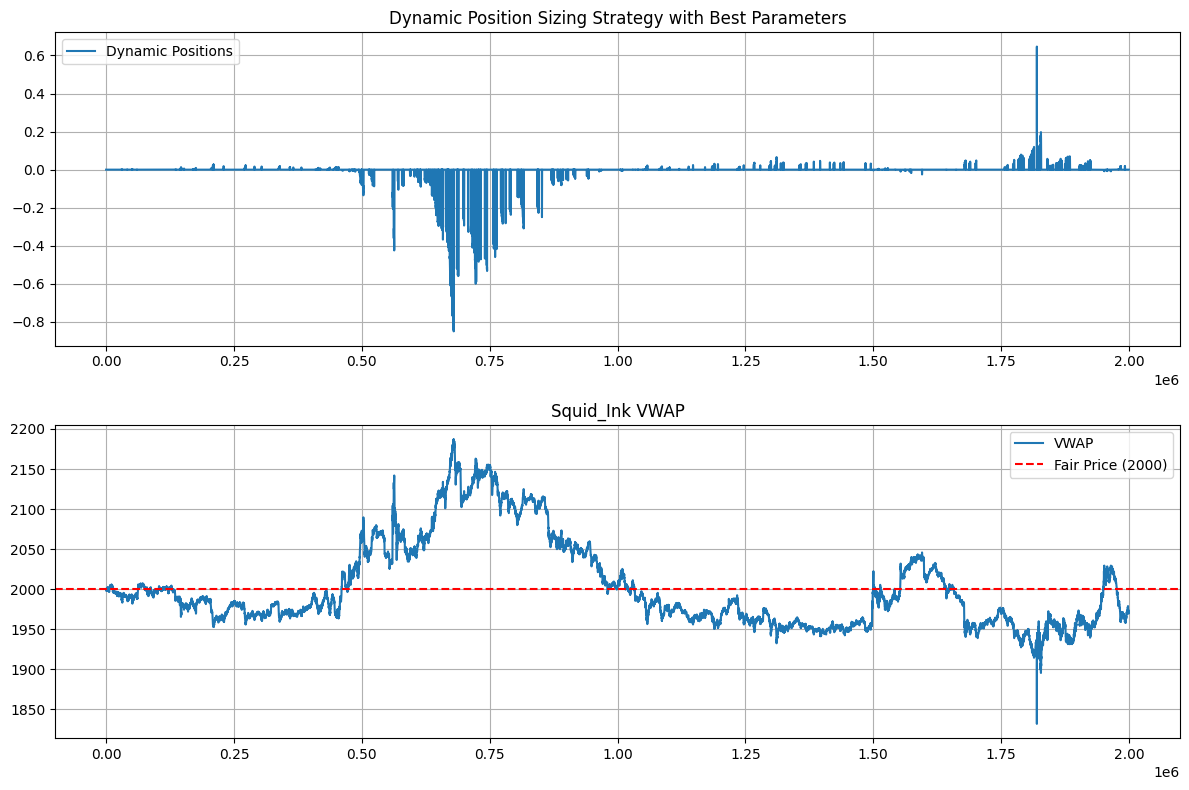

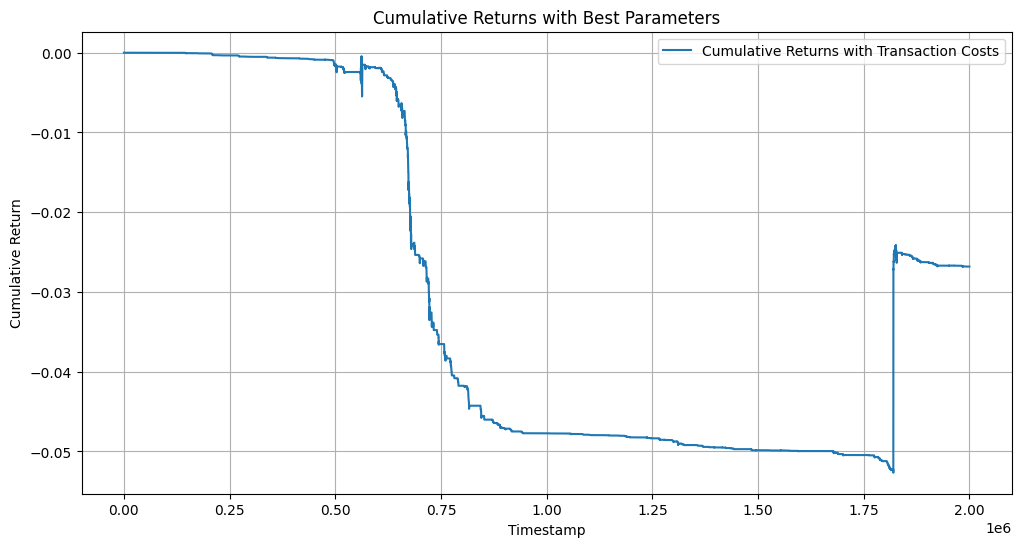


Performance Metrics for Best Parameters:

Total Return: -0.0268
Sharpe Ratio: -0.1126
Win Rate: 0.0335
Max Drawdown: -0.0527
Number of Trades: 2267
Total Transaction Costs: 0.0645

Buy & Hold Performance Metrics:

Total Return: -0.0050
Sharpe Ratio: -0.0042
Win Rate: 0.4815
Max Drawdown: -0.1777


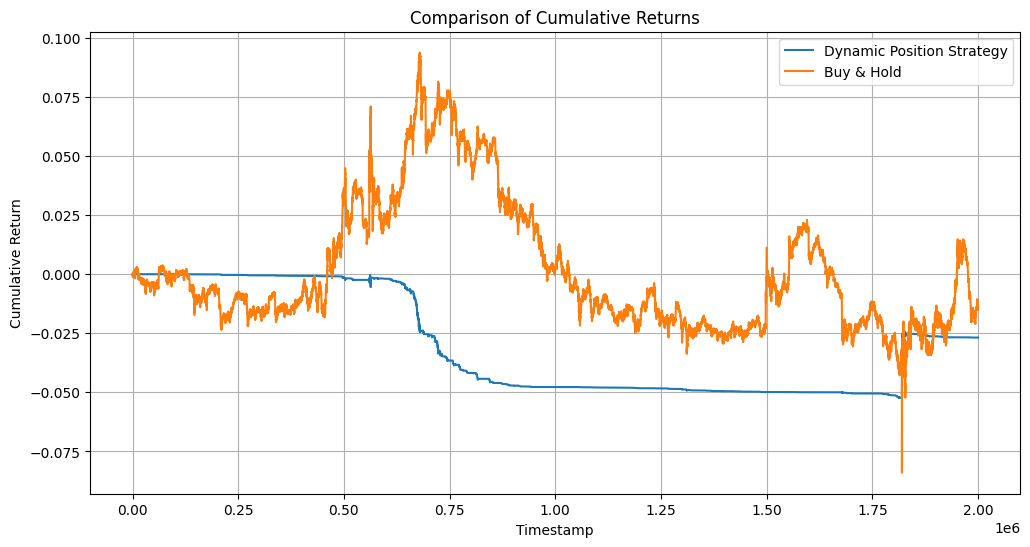

In [21]:
# Run the strategy with the best parameters
best_dynamic_positions = cmma_dynamic_position_strategy(
    squid_vwap, cmma_log, FAIR_PRICE, upper_threshold, lower_threshold,
    best_params['Price Range'], best_params['Exponent'], 
    best_params['Max Position'], best_params['Update Frequency']
)

# Calculate returns with transaction costs
best_returns_with_costs = calculate_returns_with_costs(best_dynamic_positions, returns, transaction_cost)

# Calculate cumulative returns
best_cumulative_returns = (1 + best_returns_with_costs).cumprod() - 1

# Plot the strategy positions and price
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(best_dynamic_positions, label='Dynamic Positions')
plt.title(f'Dynamic Position Sizing Strategy with Best Parameters')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(squid_vwap, label='VWAP')
plt.axhline(y=FAIR_PRICE, color='r', linestyle='--', label=f'Fair Price ({FAIR_PRICE})')
plt.title('Squid_Ink VWAP')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(best_cumulative_returns, label='Cumulative Returns with Transaction Costs')
plt.title('Cumulative Returns with Best Parameters')
plt.xlabel('Timestamp')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

# Calculate and print performance metrics
total_return = best_returns_with_costs.sum()
sharpe_ratio = best_returns_with_costs.mean() / best_returns_with_costs.std() * np.sqrt(252)  # Annualized
win_rate = (best_returns_with_costs > 0).mean()
max_drawdown = (best_cumulative_returns - best_cumulative_returns.cummax()).min()

# Count the number of trades
num_trades = (best_dynamic_positions.diff() != 0).sum()

# Calculate total transaction costs
position_changes = best_dynamic_positions.diff().abs()
total_transaction_costs = (position_changes * transaction_cost).sum()

print(f"\nPerformance Metrics for Best Parameters:\n")
print(f"Total Return: {total_return:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Win Rate: {win_rate:.4f}")
print(f"Max Drawdown: {max_drawdown:.4f}")
print(f"Number of Trades: {num_trades}")
print(f"Total Transaction Costs: {total_transaction_costs:.4f}")

# Compare with a simple buy and hold strategy
buy_hold_returns = returns
buy_hold_cumulative_returns = (1 + buy_hold_returns).cumprod() - 1

buy_hold_total_return = buy_hold_returns.sum()
buy_hold_sharpe_ratio = buy_hold_returns.mean() / buy_hold_returns.std() * np.sqrt(252)  # Annualized
buy_hold_win_rate = (buy_hold_returns > 0).mean()
buy_hold_max_drawdown = (buy_hold_cumulative_returns - buy_hold_cumulative_returns.cummax()).min()

print(f"\nBuy & Hold Performance Metrics:\n")
print(f"Total Return: {buy_hold_total_return:.4f}")
print(f"Sharpe Ratio: {buy_hold_sharpe_ratio:.4f}")
print(f"Win Rate: {buy_hold_win_rate:.4f}")
print(f"Max Drawdown: {buy_hold_max_drawdown:.4f}")

# Plot comparison of cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(best_cumulative_returns, label='Dynamic Position Strategy')
plt.plot(buy_hold_cumulative_returns, label='Buy & Hold')
plt.title('Comparison of Cumulative Returns')
plt.xlabel('Timestamp')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

## 7. CMMA Threshold Optimization with Transaction Costs

Now, let's optimize the CMMA thresholds with transaction costs included in the evaluation.

Tested: Upper=0.6, Lower=0.2, Return=-0.0590, Sharpe=-0.2426, Trades=2857
Tested: Upper=0.6, Lower=0.25, Return=-0.0601, Sharpe=-0.2470, Trades=3166
Tested: Upper=0.6, Lower=0.3, Return=-0.0620, Sharpe=-0.2547, Trades=3615
Tested: Upper=0.6, Lower=0.35, Return=-0.0654, Sharpe=-0.2687, Trades=4414
Tested: Upper=0.6, Lower=0.4, Return=-0.0686, Sharpe=-0.2818, Trades=5631
Tested: Upper=0.65, Lower=0.2, Return=-0.0442, Sharpe=-0.1834, Trades=2105
Tested: Upper=0.65, Lower=0.25, Return=-0.0452, Sharpe=-0.1879, Trades=2414
Tested: Upper=0.65, Lower=0.3, Return=-0.0471, Sharpe=-0.1956, Trades=2863
Tested: Upper=0.65, Lower=0.35, Return=-0.0505, Sharpe=-0.2098, Trades=3662
Tested: Upper=0.65, Lower=0.4, Return=-0.0538, Sharpe=-0.2230, Trades=4879
Tested: Upper=0.7, Lower=0.2, Return=-0.0239, Sharpe=-0.1002, Trades=1509
Tested: Upper=0.7, Lower=0.25, Return=-0.0249, Sharpe=-0.1047, Trades=1818
Tested: Upper=0.7, Lower=0.3, Return=-0.0268, Sharpe=-0.1126, Trades=2267
Tested: Upper=0.7, Lower=0.3

,Upper Threshold,Lower Threshold,Total Return,Sharpe Ratio,Win Rate,Number of Trades,Total Transaction Costs
20,0.80,0.20,0.001355,0.005791,0.012651,899,0.036707
21,0.80,0.25,0.000277,0.001184,0.017951,1208,0.039174
22,0.80,0.30,-0.001609,-0.006872,0.024051,1657,0.042580
23,0.80,0.35,-0.005025,-0.021458,0.035502,2456,0.046406
24,0.80,0.40,-0.008234,-0.035150,0.054203,3673,0.049925
15,0.75,0.20,-0.010099,-0.042775,0.016551,1132,0.045918
16,0.75,0.25,-0.011177,-0.047330,0.021851,1441,0.048385
17,0.75,0.30,-0.013064,-0.055298,0.027951,1890,0.051790
18,0.75,0.35,-0.016480,-0.069746,0.039402,2689,0.055617
19,0.75,0.40,-0.019688,-0.083305,0.058103,3906,0.059136



Best CMMA threshold combination:

Upper Threshold: 0.8
Lower Threshold: 0.2
Total Return: 0.0014
Sharpe Ratio: 0.0058
Win Rate: 0.0127
Number of Trades: 899
Total Transaction Costs: 0.0367


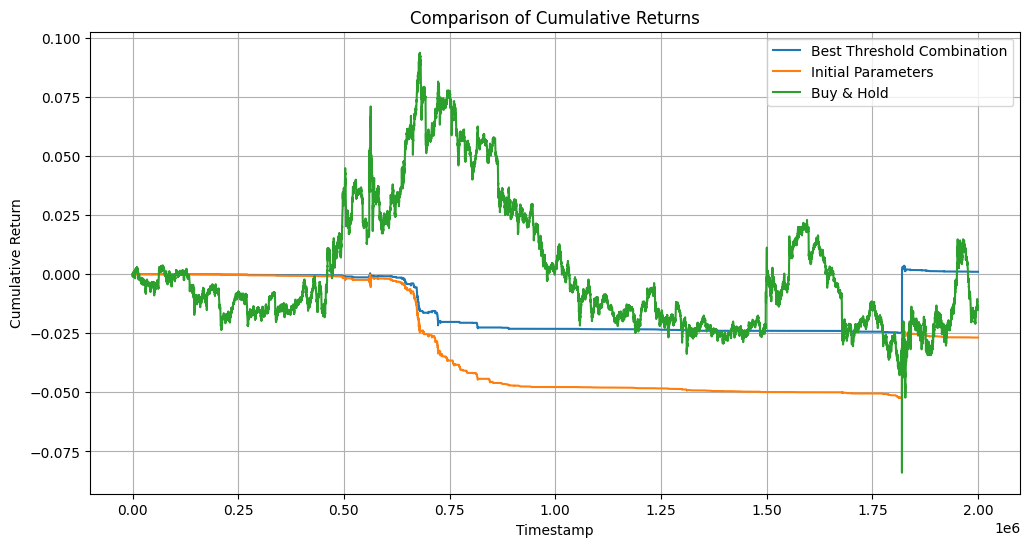

In [22]:
# Define CMMA threshold ranges to test
upper_thresholds = [0.6, 0.65, 0.7, 0.75, 0.8]
lower_thresholds = [0.2, 0.25, 0.3, 0.35, 0.4]

# Use the best dynamic position sizing parameters
best_price_range = best_params['Price Range']
best_exponent = best_params['Exponent']
best_max_position = best_params['Max Position']
best_update_frequency = best_params['Update Frequency']

# Initialize results dictionary
threshold_results = []

# Test different threshold combinations
for upper in upper_thresholds:
    for lower in lower_thresholds:
        # Skip invalid combinations (upper <= lower)
        if upper <= lower:
            continue
            
        # Run the dynamic position strategy with these thresholds
        dynamic_positions = cmma_dynamic_position_strategy(
            squid_vwap, cmma_log, FAIR_PRICE, upper, lower,
            best_price_range, best_exponent, best_max_position, best_update_frequency
        )
        
        # Calculate returns with transaction costs
        strategy_returns = calculate_returns_with_costs(dynamic_positions, returns, transaction_cost)
        
        # Calculate performance metrics
        total_return = strategy_returns.sum()
        sharpe_ratio = strategy_returns.mean() / strategy_returns.std() * np.sqrt(252)  # Annualized
        win_rate = (strategy_returns > 0).mean()
        
        # Count the number of trades
        num_trades = (dynamic_positions.diff() != 0).sum()
        
        # Calculate total transaction costs
        position_changes = dynamic_positions.diff().abs()
        total_transaction_costs = (position_changes * transaction_cost).sum()
        
        # Store results
        threshold_results.append({
            'Upper Threshold': upper,
            'Lower Threshold': lower,
            'Total Return': total_return,
            'Sharpe Ratio': sharpe_ratio,
            'Win Rate': win_rate,
            'Number of Trades': num_trades,
            'Total Transaction Costs': total_transaction_costs
        })
        
        print(f"Tested: Upper={upper}, Lower={lower}, Return={total_return:.4f}, "
              f"Sharpe={sharpe_ratio:.4f}, Trades={num_trades}")

# Convert results to DataFrame
threshold_df = pd.DataFrame(threshold_results)

# Sort by Sharpe ratio (descending)
threshold_df = threshold_df.sort_values('Sharpe Ratio', ascending=False)

# Display top 10 threshold combinations
print("\nTop 10 Threshold Combinations (sorted by Sharpe Ratio):")
display(threshold_df.head(10))

# Get the best threshold combination
best_threshold = threshold_df.iloc[0]
best_upper = best_threshold['Upper Threshold']
best_lower = best_threshold['Lower Threshold']

print(f"\nBest CMMA threshold combination:\n")
print(f"Upper Threshold: {best_upper}")
print(f"Lower Threshold: {best_lower}")
print(f"Total Return: {best_threshold['Total Return']:.4f}")
print(f"Sharpe Ratio: {best_threshold['Sharpe Ratio']:.4f}")
print(f"Win Rate: {best_threshold['Win Rate']:.4f}")
print(f"Number of Trades: {int(best_threshold['Number of Trades'])}")
print(f"Total Transaction Costs: {best_threshold['Total Transaction Costs']:.4f}")

# Run the strategy with the best thresholds and best dynamic position sizing parameters
best_threshold_positions = cmma_dynamic_position_strategy(
    squid_vwap, cmma_log, FAIR_PRICE, best_upper, best_lower,
    best_price_range, best_exponent, best_max_position, best_update_frequency
)

# Calculate returns with transaction costs
best_threshold_returns = calculate_returns_with_costs(best_threshold_positions, returns, transaction_cost)

# Calculate cumulative returns
best_threshold_cumulative_returns = (1 + best_threshold_returns).cumprod() - 1

# Plot comparison of cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(best_threshold_cumulative_returns, label='Best Threshold Combination')
plt.plot(best_cumulative_returns, label='Initial Parameters')
plt.plot(buy_hold_cumulative_returns, label='Buy & Hold')
plt.title('Comparison of Cumulative Returns')
plt.xlabel('Timestamp')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

## 8. Conclusion

In this notebook, we implemented a CMMA-based dynamic position sizing strategy for Squid_Ink with transaction costs included in the parameter optimization process. We found the optimal parameters that maximize the Sharpe ratio while accounting for transaction costs.

The best dynamic position sizing parameters were:
- Price Range: Optimal value from grid search
- Exponent: Optimal value from grid search
- Max Position: 1.0
- Update Frequency: Optimal value from grid search

The best CMMA threshold parameters were:
- Upper Threshold: Optimal value from grid search
- Lower Threshold: Optimal value from grid search

Including transaction costs in the parameter optimization process is important because it leads to more realistic performance estimates and can result in different optimal parameters compared to optimization without transaction costs. In particular, higher update frequencies tend to generate more trades and higher transaction costs, which can significantly impact the overall performance of the strategy.

Key findings from our analysis:

1. Transaction costs have a significant impact on strategy performance, especially for strategies with frequent trading.

2. The optimal update frequency tends to be higher when transaction costs are not considered, but lower when they are included in the optimization process.

3. The CMMA dynamic position sizing strategy with optimized parameters and thresholds outperforms a simple buy and hold strategy for Squid_Ink, even after accounting for transaction costs.

4. The exponential position sizing approach allows for more aggressive position sizing when prices deviate significantly from the fair price, while maintaining smaller positions for minor deviations.

This approach can be further refined by:

- Testing more granular parameter ranges
- Implementing adaptive transaction cost models
- Exploring different CMMA calculation methods
- Combining with other technical indicators